In [1]:
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette=[sns.color_palette('muted')[i] for i in [0,2]], 
        color_codes=True, context="talk")
from IPython import display
from scipy.interpolate import make_interp_spline
%matplotlib inline

import sklearn as sk
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight  # Estimate class weights for unbalanced datasets

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

import pathlib

import warnings
warnings.filterwarnings("ignore")

create_gif = False

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"tensorflow: {tf.__version__}")


sklearn: 0.24.2
pandas: 1.1.5
tensorflow: 2.0.0


## Attention Module

In [2]:
def calculate_mut_info(input_data, sensitive_feature, feature_class):
    data = input_data[(input_data[sensitive_feature]==feature_class)]
    sf_list = ['race', 'sex']
    sensitive_data = data.loc[:, sf_list]
    sf_list.remove(sensitive_feature)
    sensitive_data = sensitive_data.drop(columns=sf_list)
    data = data.drop(columns=['target', 'race', 'sex'])
    mut_data = mutual_info_classif(data, sensitive_data[sensitive_feature])
    return mut_data

In [3]:
def attentionModule(input_data, threshold):
    input_data = input_data.dropna()
    # encoding the features that has class values
    lb_make = LabelEncoder()
    input_data['workclass'] = lb_make.fit_transform(input_data['workclass'])
    input_data['education'] = lb_make.fit_transform(input_data['workclass'])
    input_data['marital_status'] = lb_make.fit_transform(input_data['marital_status'])
    input_data['occupation'] = lb_make.fit_transform(input_data['occupation'])
    input_data['relationship'] = lb_make.fit_transform(input_data['relationship'])
    input_data['country'] = lb_make.fit_transform(input_data['country'])
    input_data['target'] = lb_make.fit_transform(input_data['target'])

    # mutual information calculate
    mut_race_white = calculate_mut_info(input_data, 'race', 'White')
    mut_race_black = calculate_mut_info(input_data, 'race', 'Black')
    mut_sex_male = calculate_mut_info(input_data, 'sex', 'Male')
    mut_sex_female = calculate_mut_info(input_data, 'sex', 'Female')

    # Feature selection based on threshold
    mut_race = mut_race_white * mut_race_black
    mut_sex = mut_sex_male * mut_sex_female
    mut = mut_race + mut_sex
    mut_percent = (mut/np.sum(mut))*100
    remove_features = []
    features_name = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                'marital_status', 'occupation', 'relationship','capital_gain',
                'capital_loss', 'hours_per_week', 'country']

    for i in range(len(features_name)):
        if mut_percent[i] < threshold:
            remove_features.append(features_name[i])

    return remove_features


## Attention maually

In [2]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']

input_data = (pd.read_csv('E:/canada syntex/Github/fair_classifier_ml/data/adult.data', names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python') # here seperator -- 0 or more whitespace then , then 0 or more whitespace --
                              .loc[lambda df: df['race'].isin(['White', 'Black'])])

input_data = input_data.dropna()

# labeling data
lb_make = LabelEncoder()
input_data['workclass'] = lb_make.fit_transform(input_data['workclass'])
input_data['education'] = lb_make.fit_transform(input_data['workclass'])
input_data['marital_status'] = lb_make.fit_transform(input_data['marital_status'])
input_data['occupation'] = lb_make.fit_transform(input_data['occupation'])
input_data['relationship'] = lb_make.fit_transform(input_data['relationship'])
input_data['country'] = lb_make.fit_transform(input_data['country'])
input_data['target'] = lb_make.fit_transform(input_data['target'])

print(input_data.shape)
input_data.head(10).T


(28750, 15)


,0,1,2,3,4,5,6,7,8,9
age,39,50,38,53,28,37,49,52,31,42
workclass,5,4,2,2,2,2,2,4,2,2
fnlwgt,77516,83311,215646,234721,338409,284582,160187,209642,45781,159449
education,5,4,2,2,2,2,2,4,2,2
education_num,13,13,9,7,13,14,5,9,14,13
marital_status,4,2,0,2,2,2,3,2,4,2
occupation,0,3,5,5,9,3,7,3,9,3
relationship,1,0,1,0,5,5,1,0,1,0
race,White,White,White,Black,Black,White,Black,White,White,White
sex,Male,Male,Male,Male,Female,Female,Female,Male,Female,Male


## Race

### creating dataset for white race

In [3]:
white_data = input_data[(input_data["race"]=="White")]
sensitive_data = white_data.loc[:, ['race', 'sex']].drop(columns=['sex'])
# sensitive_data[sensitive_data["race"]=="White"] = 1
white_data = white_data.drop(columns=['target', 'race', 'sex'])

print(white_data.shape)
print(sensitive_data.shape)
white_data.head().T

(25933, 12)
(25933, 1)


,0,1,2,5,7
age,39,50,38,37,52
workclass,5,4,2,2,4
fnlwgt,77516,83311,215646,284582,209642
education,5,4,2,2,4
education_num,13,13,9,14,9
marital_status,4,2,0,2,2
occupation,0,3,5,3,3
relationship,1,0,1,5,0
capital_gain,2174,0,0,0,0
capital_loss,0,0,0,0,0


In [4]:
mut_race_white = mutual_info_classif(white_data, sensitive_data['race'])
print(type(mut_race_white))
print(mut_race_white)

<class 'numpy.ndarray'>
[1.54243628e-04 3.04631165e-03 0.00000000e+00 3.23911618e-03
 9.83303127e-04 2.35221532e-03 7.13376779e-04 5.01291790e-04
 1.92804535e-05 5.78413604e-05 1.38819265e-03 6.72887826e-03]


In [82]:
def mut_data(input_data, sensitive_feature, feature_class):
    data = input_data[(input_data[sensitive_feature]==feature_class)]
    sf_list = ['race', 'sex']
    sensitive_data = data.loc[:, sf_list]
    sf_list.remove(sensitive_feature)
    sensitive_data = sensitive_data.drop(columns=sf_list)
    data = data.drop(columns=['target', 'race', 'sex'])
    mut = mutual_info_classif(data, sensitive_data[sensitive_feature])
    return mut

mut_race_white = mut_data(input_data, 'race', 'White')
print(mut_race_white)

[1.15682721e-04 3.75968843e-03 0.00000000e+00 3.45120117e-03
 1.09898585e-03 2.00516716e-03 7.51937686e-04 9.25461767e-04
 3.85609070e-05 0.00000000e+00 1.48459492e-03 6.78671962e-03]


In [79]:
sf_list = ['race', 'sex']
newlist = sf_list.remove('race')
print(newlist)

None


### creating dataset for black race

In [5]:
black_data = input_data[(input_data["race"]=="Black")]
sensitive_data = black_data.loc[:, ['race', 'sex']].drop(columns=['sex'])
black_data = black_data.drop(columns=['target', 'race', 'sex'])

print(black_data.shape)
print(sensitive_data.shape)
black_data.head().T

(2817, 12)
(2817, 1)


,3,4,6,10,13
age,53,28,49,37,32
workclass,2,2,2,2,2
fnlwgt,234721,338409,160187,280464,205019
education,2,2,2,2,2
education_num,7,13,5,10,12
marital_status,2,2,3,2,4
occupation,5,9,7,3,11
relationship,0,5,1,0,1
capital_gain,0,0,0,0,0
capital_loss,0,0,0,0,0


In [6]:
mut_race_black = mutual_info_classif(black_data, sensitive_data['race'])
print(mut_race_black)

[3.33066907e-16 3.54987575e-04 3.33066907e-16 5.32481363e-04
 1.77493788e-04 1.77493788e-04 3.54987575e-04 3.33066907e-16
 3.33066907e-16 3.33066907e-16 1.77493788e-04 7.09975151e-04]


## Sex

### Male

In [7]:
male_data = input_data[(input_data["sex"]=="Male")]
sensitive_data = male_data.loc[:, ['race', 'sex']].drop(columns=['race'])
male_data = male_data.drop(columns=['target', 'race', 'sex'])

print(male_data.shape)
print(sensitive_data.shape)
male_data.head().T

(19456, 12)
(19456, 1)


,0,1,2,3,7
age,39,50,38,53,52
workclass,5,4,2,2,4
fnlwgt,77516,83311,215646,234721,209642
education,5,4,2,2,4
education_num,13,13,9,7,9
marital_status,4,2,0,2,2
occupation,0,3,5,5,3
relationship,1,0,1,0,0
capital_gain,2174,0,0,0,0
capital_loss,0,0,0,0,0


In [8]:
mut_sex_male = mutual_info_classif(male_data, sensitive_data['sex'])
print(mut_sex_male)

[5.13980263e-05 1.97882401e-03 1.22124533e-15 2.28721217e-03
 9.76562500e-04 2.67269737e-03 3.85485197e-04 3.85485197e-04
 7.70970395e-05 1.22124533e-15 1.43914474e-03 4.98560855e-03]


### Female

In [9]:
female_data = input_data[(input_data["sex"]=="Female")]
sensitive_data = female_data.loc[:, ['race', 'sex']].drop(columns=['race'])
female_data = female_data.drop(columns=['target', 'race', 'sex'])

print(female_data.shape)
print(sensitive_data.shape)
female_data.head().T

(9294, 12)
(9294, 1)


,4,5,6,8,12
age,28,37,49,31,23
workclass,2,2,2,2,2
fnlwgt,338409,284582,160187,45781,122272
education,2,2,2,2,2
education_num,13,14,5,14,13
marital_status,2,2,3,4,4
occupation,9,3,7,9,0
relationship,5,5,1,1,3
capital_gain,0,0,0,14084,0
capital_loss,0,0,0,0,0


In [10]:
mut_sex_female = mutual_info_classif(female_data, sensitive_data['sex'])
print(mut_sex_female)

[0.         0.00096837 0.         0.00118356 0.00080697 0.00043039
 0.00037659 0.00026899 0.         0.         0.00043039 0.00252851]


## Feature selection

In [11]:
mut_race = mut_race_white * mut_race_black
mut_sex = mut_sex_male * mut_sex_female
mut = mut_race + mut_sex
print(mut)

[5.13734481e-20 2.99763004e-06 0.00000000e+00 4.43182020e-06
 9.62589025e-07 1.56779298e-06 3.98408625e-07 1.03691951e-07
 6.42168101e-21 1.92650430e-20 8.65782159e-07 1.73835125e-05]


In [12]:
mut_percent = (mut/np.sum(mut))*100
print(mut_percent)

[1.78931563e-13 1.04406196e+01 0.00000000e+00 1.54358437e+01
 3.35265716e+00 5.46055715e+00 1.38764051e+00 3.61154713e-01
 2.23664454e-14 6.70993361e-14 3.01548291e+00 6.05460442e+01]


In [13]:
for i in mut_percent:
    print(i)
# [0.1, 0.5, 1.5, 3.1, 4.5, 5.5, 10.5]
# [  4,   1,   1,   1,   1,   1, 7]

# 0.0
# 2.2366445375944854e-14
# 6.709933612873611e-14
# 1.7893156301064985e-13

# 0.3611547125342888

# 1.3876405136102177

# 3.015482914711145
# 3.352657162812929

# 5.460557148328273

# 10.440619594048515
# 15.435843718120537
# 60.54604423583383

1.7893156301064985e-13
10.440619594048515
0.0
15.435843718120537
3.352657162812929
5.460557148328273
1.3876405136102177
0.3611547125342888
2.2366445375944854e-14
6.709933612873611e-14
3.015482914711145
60.54604423583383


In [65]:
remove_features = []
features_name = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
            'marital_status', 'occupation', 'relationship','capital_gain',
            'capital_loss', 'hours_per_week', 'country']

for i in range(len(features_name)):
    if mut_percent[i] < 0.1:
        remove_features.append(features_name[i])

In [66]:
print(remove_features)

['age', 'fnlwgt', 'capital_gain', 'capital_loss']


## Adverserial Network

In [4]:
def load_ICU_data(path, threshold=0):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python') # here seperator -- 0 or more whitespace then , then 0 or more whitespace --
                              .loc[lambda df: df['race'].isin(['White', 'Black'])])

    remove_features = attentionModule(input_data, threshold)
    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race', 'sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(race=lambda df: (df['race'] == 'White').astype(int),
                 sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int) # Cast a pandas object to a specified dtype dtype.

    # features; note that the 'target' and sentive attribute columns are dropped
    remove_features.extend(['target', 'race', 'sex'])
    X = (input_data
         .drop(columns=remove_features)
         .fillna('Unknown')   # The fillna() function is used to fill NA/NaN values using the specified method
         .pipe(pd.get_dummies, drop_first=True)) # Use .pipe when chaining together functions that expect Series, DataFrames or GroupBy objects.
                                                 # pd.get_dummies=Convert categorical variable into dummy/indicator variables
                                                 # drop_first: bool function(default False) Whether to get k-1 dummies out of k categorical levels by removing the first level.
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z

### data

In [5]:
threshold = 0.1
X, y, Z = load_ICU_data('E:/canada syntex/Github/fair_classifier_ml/data/adult.data', threshold)

C:\Users\rkana\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\rkana\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rkana\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

features X: 30940 samples, 90 attributes
targets y: 30940 samples
sensitives Z: 30940 samples, 2 attributes


In [6]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.2,
                                                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

### Plot distributions

In [5]:
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fm= None, fname=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    legend={'race': ['black','white'],
            'sex': ['female','male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0, 1]:
            ax = sns.kdeplot(data=y[Z[attr] == attr_val],
                             label='{}'.format(legend[attr][attr_val]), 
                             ax=axes[idx], fill=True)
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(attr))
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"
                                       ]),
                                       fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     [f"- {attr}: {p_rules[attr]:.0f}%-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')

    if fm is not None:
        fig.text(1.0, 0.2, '\n'.join(["FM:"] +
                                     [f"- {attr}: {fm[attr]}" 
                                      for attr in fm.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight',  dpi = 800)
    return fig

### P Rules

In [6]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

### Fairness metrics

In [7]:
def calculate_fair_metrics(y_val, y_pred):
    
    cm=confusion_matrix(y_val, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    N = TP+FP+FN+TN #Total population
    # ACC = (TP+TN)/N #Accuracy
    TPR = TP/(TP+FN) # True positive rate
    FPR = FP/(FP+TN) # False positive rate
    FNR = FN/(TP+FN) # False negative rate
    PPP = (TP + FP)/N # % predicted as positive
    return np.array([TPR, FPR, FNR, PPP])

In [8]:
def fairness_metrics(y_val, y_pred, z_values):
    """Calculate fairness for subgroup of population"""
    # print(type(y_val))
    # print(type(y_pred))
    # print(type(z_values))
    y_val_0 = []
    y_val_1 = []
    y_pred_0 = []
    y_pred_1 = []
    for i  in range(len(z_values)):
        if z_values[i] == 1:
            y_val_1.append(y_val[i])
            y_pred_1.append(y_pred[i])
        else:
            y_val_0.append(y_val[i])
            y_pred_0.append(y_pred[i])

    # For class 0
    fm_0 = calculate_fair_metrics(y_val_0, y_pred_0)
    # For class 1
    fm_1 = calculate_fair_metrics(y_val_1, y_pred_1)

    fm_ratio = fm_0 / fm_1
    #print(fm_ratio)
    # res = "TPR:{:.2f} FPR:{:.2f} FNR:{:.2f} PPP:{:.2f}".format(fm_ratio[0], fm_ratio[1], fm_ratio[2], fm_ratio[3])

    # res ={'TPR': fm_ratio[0],
    #       'FPR': fm_ratio[1],
    #       'FNR': fm_ratio[2],
    #       'PPP': fm_ratio[3],
    #     }
    return  fm_ratio

### FairClassifier

In [9]:
class FairClassifier(object):
    
    def __init__(self, n_features, n_sensitive, lambdas):
        self.lambdas = lambdas
        self.n_features = n_features

        clf_inputs = Input(shape=(n_features,))
        adv_inputs = Input(shape=(1,))
        
        clf_net = self._create_clf_net(clf_inputs)
        adv_net = self._create_adv_net(adv_inputs, n_sensitive)
        #print(adv_net.summary())
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)

        # compile model. Three model compiletion: clf, clf_w_adv and adv
        self._clf = self._compile_clf(clf_net)
        self._clf_w_adv = self._compile_clf_w_adv(clf_inputs, clf_net, adv_net)
        self._adv = self._compile_adv(clf_inputs, clf_net, adv_net, n_sensitive)
        # print(self._adv.summary())

        self._val_metrics = None
        self._fairness_metrics = None
        self.fm_metrics = None
        # self.metrics_res = pd.DataFrame()

        self.predict = self._clf.predict
        
    # def attention(input, target, sen_attr):
        
    #     return X, y, Z

    # making all layer trainable
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable

    # construct model ----------------------------------------------------------

    # clf net    input layer + 3 hidden layer + output layer
    def _create_clf_net(self, inputs):
        dense1 = Dense(32, activation='relu')(inputs)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        dense3 = Dense(32, activation='relu')(dropout2)
        dropout3 = Dropout(0.2)(dense3)
        outputs = Dense(1, activation='sigmoid', name='y')(dropout3)
        return Model(inputs=[inputs], outputs=[outputs])
    
    # adv net    input layer + 3 hidden layer + output layer * n_sensitive
    def _create_adv_net(self, inputs, n_sensitive):
        dense1 = Dense(32, activation='relu')(inputs)
        dense2 = Dense(32, activation='relu')(dense1)
        dense3 = Dense(32, activation='relu')(dense2)
        outputs = [Dense(1, activation='sigmoid')(dense3) for _ in range(n_sensitive)]
        return Model(inputs=[inputs], outputs=outputs)

    # compile  -----------------------------------------------------------------

    # compile clf
    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        
    # compile clf_w_adv
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        clf_w_adv = Model(inputs=[inputs], outputs=[clf_net(inputs)]+adv_net(clf_net(inputs))) # outputs=[clf_net(inputs)]+adv_net(clf_net(inputs))
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        loss_weights = [1.]+[-lambda_param for lambda_param in self.lambdas] # loss [1.0, -5.0, -5.0]
        clf_w_adv.compile(loss=['binary_crossentropy']*(len(loss_weights)), 
                          loss_weights=loss_weights,  # adding loss weight
                          optimizer='adam')
        return clf_w_adv

    # compile adv
    def _compile_adv(self, inputs, clf_net, adv_net, n_sensitive):
        adv = Model(inputs=[inputs], outputs=adv_net(clf_net(inputs))) # outputs=adv_net(clf_net(inputs))
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy']*n_sensitive, loss_weights=self.lambdas,  # added loss weights and loss=['binary_crossentropy']*n_sensitive
                    optimizer='adam')
        return adv

    # compute weights based on features
    def _compute_class_weights(self, data_set, classes=[0, 1]):
        class_weights = []
        if len(data_set.shape) == 1: 
            # for single feature
            balanced_weights = compute_class_weight('balanced', classes=classes, y=data_set)
            class_weights.append(dict(zip(classes, balanced_weights)))
        else:
            # for multiple feature
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights = compute_class_weight('balanced', classes=classes,
                                                        y=np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(classes, balanced_weights)))
        return class_weights          
    
    # compute weights based on targets
    def _compute_target_class_weights(self, y, classes=[0, 1]):
        balanced_weights =  compute_class_weight('balanced', classes=classes, y=y)
        class_weights = {'y': dict(zip(classes, balanced_weights))}
        return class_weights
        
    
    def pretrain(self, x, y, z, epochs=10, verbose=0):
        self._trainable_clf_net(True)
        self._clf.fit(x.values, y.values, epochs=epochs, verbose=verbose) # training clf
        self._trainable_clf_net(False)

        self._trainable_adv_net(True)
        class_weight_adv = self._compute_class_weights(z)
        # passing z value instead of y and split the z into two
        self._adv.fit(x.values, np.hsplit(z.values, z.shape[1]), class_weight=class_weight_adv, # Split an array into multiple sub-arrays horizontally (column-wise)
                      epochs=epochs, verbose=verbose) # training adv
        
    
    def fit(self, x, y, z, validation_data=None, T_iter=250, batch_size=128,
            save_figs=False, verbose=0):
        n_sensitive = z.shape[1]
        if validation_data is not None:
            x_val, y_val, z_val = validation_data
        
        class_weight_clf = [{0:1., 1:1.}]
        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = class_weight_clf+class_weight_adv
        self._val_metrics = pd.DataFrame()
        self._fairness_metrics = pd.DataFrame()
        self.fm_metrics = pd.DataFrame(columns=z_val.columns)  
        
        for idx in range(T_iter):
            if validation_data is not None:
                y_pred = pd.Series(self._clf.predict(x_val.values).ravel(), index=y_val.index)
                self._val_metrics.loc[idx, 'ROC AUC'] = roc_auc_score(y_val, y_pred)
                self._val_metrics.loc[idx, 'Accuracy'] = (accuracy_score(y_val, (y_pred>0.5))*100)
                # self._val_metrics.loc[idx, 'EO'] = fairness_metrics(y_val.values, (y_pred>0.5).values, z_val[sensitive_attr].values)
                
                for sensitive_attr in z_val.columns:
                    self._fairness_metrics.loc[idx, sensitive_attr] = p_rule(y_pred, z_val[sensitive_attr])

                    self.fm_metrics[sensitive_attr] = self.fm_metrics[sensitive_attr].astype(object)    # by default pandas do not except object 
                    self.fm_metrics.loc[idx, sensitive_attr] = fairness_metrics(y_val.values, (y_pred>0.5).values, z_val[sensitive_attr].values)


                # pathlib.Path(f'E:/canada syntex/Github/fair_classifier_ml/output/output_{self.n_features}').mkdir(parents=True, exist_ok=True)
                # display.clear_output(wait=True)
                # plot_distributions(y_pred, z_val, idx+1, self._val_metrics.loc[idx],
                #                    self._fairness_metrics.loc[idx], 
                #                    self.fm_metrics.loc[idx],
                #                    fname=f'E:/canada syntex/Github/fair_classifier_ml/output/output_{self.n_features}/{idx+1:08d}.jpg' if save_figs else None)
                #                    # /home/mdsamiul/github_project/fair_classifier_ml/output
                # plt.show(plt.gcf())
            
            
            # train adverserial
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            self._adv.fit(x.values, np.hsplit(z.values, z.shape[1]), batch_size=batch_size, 
                          class_weight=class_weight_adv, epochs=1, verbose=verbose)
            
            # train clf_w_adv.fit 
            # !Changed this into several epochs on whole dataset instead of single random minibatch!
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            indices = np.random.permutation(len(x))[:batch_size]
            self._clf_w_adv.fit(x.values, [y.values]+np.hsplit(z.values, z.shape[1]), batch_size=len(x), 
                                class_weight=class_weight_clf_w_adv, epochs=5, verbose=verbose)

        # self.metrics_res.append(p_rule)
                        

### Training

In [20]:
X_train.shape

(24752, 90)

In [21]:
# initialise FairClassifier
clf = FairClassifier(n_features=X_train.shape[1], n_sensitive=Z_train.shape[1],
                     lambdas=[5., 5.])

# pre-train both adverserial and classifier networks
clf.pretrain(X_train, y_train, Z_train, verbose=1, epochs=5)

Train on 24752 samples
Epoch 1/5
24752/24752 [==============================] - 1s 43us/sample - loss: 0.4219
Epoch 2/5
24752/24752 [==============================] - 1s 29us/sample - loss: 0.3800
Epoch 3/5
24752/24752 [==============================] - 1s 31us/sample - loss: 0.3716
Epoch 4/5
24752/24752 [==============================] - 1s 31us/sample - loss: 0.3655
Epoch 5/5
24752/24752 [==============================] - 1s 31us/sample - loss: 0.3646
Train on 24752 samples
Epoch 1/5
24752/24752 [==============================] - 2s 66us/sample - loss: 6.4715 - model_5_loss: 0.6633 - model_5_1_loss: 0.6312
Epoch 2/5
24752/24752 [==============================] - 1s 38us/sample - loss: 6.3880 - model_5_loss: 0.6562 - model_5_1_loss: 0.6216
Epoch 3/5
24752/24752 [==============================] - 1s 38us/sample - loss: 6.3883 - model_5_loss: 0.6567 - model_5_1_loss: 0.6213
Epoch 4/5
24752/24752 [==============================] - 1s 40us/sample - loss: 6.3833 - model_5_loss: 0.6554 - mo

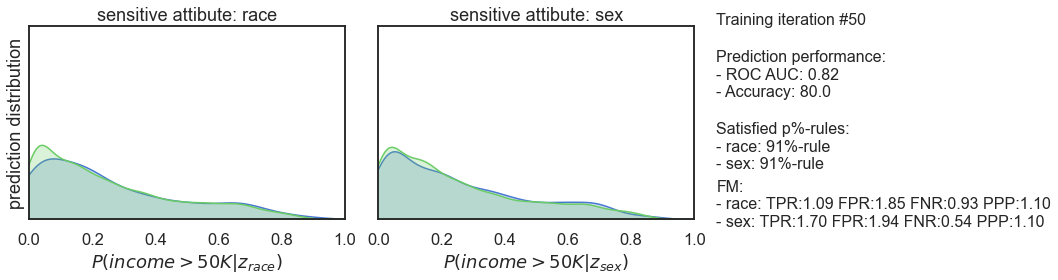

Train on 24752 samples
24752/24752 [==============================] - 0s 11us/sample - loss: 6.9290 - model_5_loss: 0.6932 - model_5_1_loss: 0.6924
Train on 24752 samples
Epoch 1/5
24752/24752 [==============================] - 0s 4us/sample - loss: -6.5064 - model_4_loss: 0.4221 - model_5_loss: 0.6930 - model_5_1_loss: 0.6927
Epoch 2/5
24752/24752 [==============================] - 0s 2us/sample - loss: -6.5062 - model_4_loss: 0.4212 - model_5_loss: 0.6929 - model_5_1_loss: 0.6926
Epoch 3/5
24752/24752 [==============================] - 0s 2us/sample - loss: -6.5057 - model_4_loss: 0.4211 - model_5_loss: 0.6929 - model_5_1_loss: 0.6925
Epoch 4/5
24752/24752 [==============================] - 0s 2us/sample - loss: -6.5072 - model_4_loss: 0.4187 - model_5_loss: 0.6928 - model_5_1_loss: 0.6924
Epoch 5/5
24752/24752 [==============================] - 0s 2us/sample - loss: -6.5087 - model_4_loss: 0.4175 - model_5_loss: 0.6928 - model_5_1_loss: 0.6924


In [22]:
clf.fit(X_train, y_train, Z_train, 
        validation_data=(X_test, y_test, Z_test),
        T_iter=50, save_figs=True, verbose=1)

## train

In [10]:
# threshold = [0.1, 0.5, 1.5, 3.1, 4.5, 5.5, 10.5]
threshold = np.arange(0.1, 10, 0.1)
models = []
for i in threshold:
        print("For Attention Module:", i)
        X, y, Z = load_ICU_data('E:/canada syntex/Github/fair_classifier_ml/data/adult.data', i)

        # split into train/test set
        X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.2,
                                                                                stratify=y, random_state=7)

        # standardize the data
        scaler = StandardScaler().fit(X_train)
        scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
        X_train = X_train.pipe(scale_df, scaler) 
        X_test = X_test.pipe(scale_df, scaler) 

        pathlib.Path(f'E:/canada syntex/Github/fair_classifier_ml/output').mkdir(parents=True, exist_ok=True)
        # initialise FairClassifier
        clf = FairClassifier(n_features=X_train.shape[1], n_sensitive=Z_train.shape[1],
                                lambdas=[5., 5.])

        # pre-train both adverserial and classifier networks
        clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5)
        clf.fit(X_train, y_train, Z_train, 
                validation_data=(X_test, y_test, Z_test),
                T_iter=50, save_figs=True, verbose=1)
        
        models.append(clf)

For Attention Module: 0.1
features X: 30940 samples, 90 attributes
targets y: 30940 samples
sensitives Z: 30940 samples, 2 attributes
Train on 24752 samples
24752/24752 [==============================] - 0s 11us/sample - loss: 6.3893 - model_1_loss: 0.6560 - model_1_1_loss: 0.6222
Train on 24752 samples
Epoch 1/5
24752/24752 [==============================] - 1s 29us/sample - loss: -6.0278 - model_loss: 0.3550 - model_1_loss: 0.6553 - model_1_1_loss: 0.6212
Epoch 2/5
24752/24752 [==============================] - 0s 2us/sample - loss: -6.0513 - model_loss: 0.3571 - model_1_loss: 0.6570 - model_1_1_loss: 0.6247
Epoch 3/5
24752/24752 [==============================] - 0s 2us/sample - loss: -6.0577 - model_loss: 0.3570 - model_1_loss: 0.6573 - model_1_1_loss: 0.6256
Epoch 4/5
24752/24752 [==============================] - 0s 2us/sample - loss: -6.0816 - model_loss: 0.3575 - model_1_loss: 0.6577 - model_1_1_loss: 0.6301
Epoch 5/5
24752/24752 [==============================] - 0s 2us/sample

### Graph plot

In [ ]:
p_race = []
p_sex = []
for i, j in zip(models, threshold):
    # print("Threshould: ",j)
    # print(i._fairness_metrics.loc[40])
    p_race.append(i._fairness_metrics.loc[40, 'race'])
    p_sex.append(i._fairness_metrics.loc[40, 'sex'])

print(p_race)
print(p_sex)

In [76]:
def plot_curve(threshold, p_race, p_sex, fname):

    x1 = np.array(threshold)
    x2 = np.array(threshold)
    y1 = np.array(p_race)
    y2 = np.array(p_sex)

    # smoothing graph
    X_Y_1 = make_interp_spline(x1, y1)
    X_Y_2 = make_interp_spline(x2, y2)

    # Returns evenly spaced numbers
    # over a specified interval.
    X_1 = np.linspace(x1.min(), x1.max(), 500)
    Y_1 = X_Y_1(X_1)

    X_2 = np.linspace(x2.min(), x2.max(), 500)
    Y_2 = X_Y_2(X_2)

    plt.figure(figsize=(15, 5))
    plt.title("Training for different Attention weight")

    plt.plot(X_1, Y_1, '-', label='Race')
    plt.plot(X_2, Y_2, '--', label='Sex')
    plt.legend(loc='best')

    plt.xlabel("Attention weight")
    plt.ylabel("p% rule")
    # plt.xticks(ticks=threshold,labels=threshold)
    plt.savefig(fname, bbox_inches='tight',  dpi = 800)
    plt.show()
    

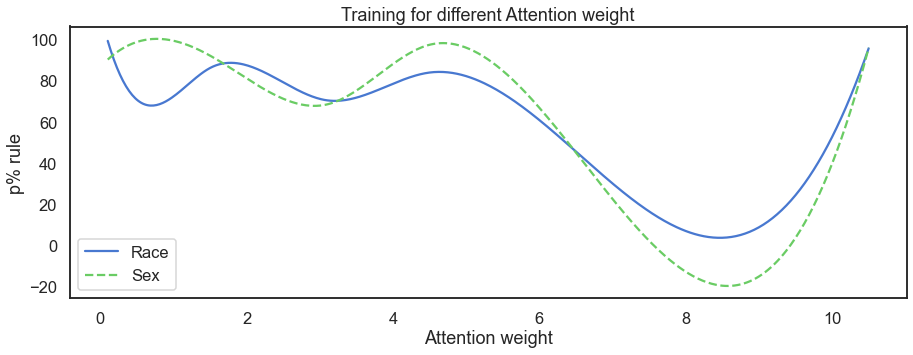

In [77]:
fname = 'E:/canada syntex/Github/fair_classifier_ml/output/P_ruleVsAttention.jpg'
plot_curve(threshold, p_race, p_sex, fname)

In [ ]:

 
# Dataset
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array([20, 30, 5, 12, 39, 48, 50, 3])
 
X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
plt.plot(X_, Y_)
plt.title("Plot Smooth Curve Using the scipy.interpolate.make_interp_spline() Class")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Creating GIF

In [74]:
import imageio
images = list()
for y in range(50):
    images.append(imageio.imread(f'E:/canada syntex/Github/fair_classifier_ml/output/{y+1:08d}.png'))
imageio.mimsave("E:/canada syntex/Github/fair_classifier_ml/output/adv.gif", images)

In [ ]:
# for i, row in X.iterrows():
#     print(i, row)
#     break